In [26]:
import matplotlib
import numpy as np
import pysptk
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import librosa.display
import seaborn

WAV = "sm04010103201"

In [7]:
seaborn.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16,5)

### Plotting utility

In [8]:
def pplot(sp, envelope, title="no title"):
    plt.plot(sp, "b-", linewidth=2.0, label="Original log spectrum 20log|X(w)|")
    plt.plot(20.0/np.log(10)*envelope, "r-", linewidth=3.0, label=title)
    plt.xlim(0, len(sp))
    plt.xlabel("frequency bin")
    plt.ylabel("log amplitude")
    plt.legend(prop={'size': 20})

## Load audio file

In [27]:
fs, x = wavfile.read("./wav/"+WAV+".wav") 
# fs = sample rate ili frequency sample iz učitanog wava = 16 000 Hz --> reduction of a continuous-time signal to discrete-time signal
# sound wave (continuous signal) to a sequence of samples (discrete-time signal)
# 16 000 - za signale govora je dovoljna frekvencija uzorkovanja od 16 kHz - frekvencija uzorkovanja mora biti dva puta veća od najviše frekvencije govora
print(fs)
assert fs == 16000 # provjerava je li sample rate 16 000 Hz
x = x.astype(np.float64) 
#x = x
# x je numpay array - data read from WAV file
print(x.shape) # dužina arrayja x

16000
(160082,)


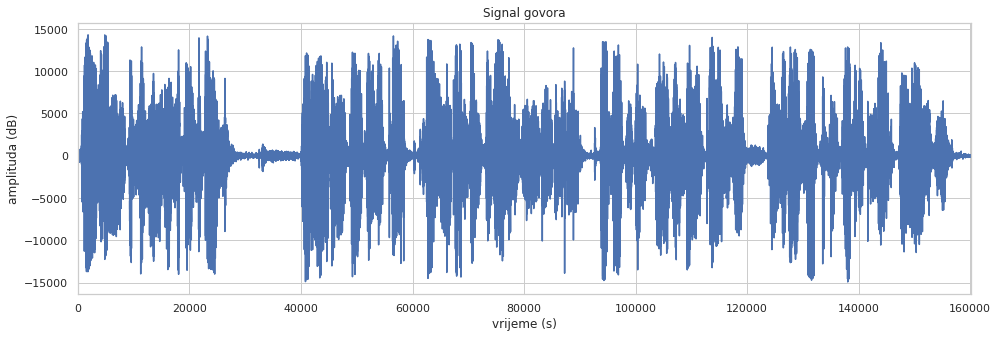

In [28]:
plt.plot(x)
plt.xlim(0, len(x))

#koristeći librosu
#librosa.display.waveplot(x, sr=fs) # sr je sampling rate, frekvencija uzrokovanja x-a

plt.title("Signal govora")
plt.xlabel("vrijeme (s)") # --> trebalo bi prikazati u sekundama (1 - 6 - podijeliti s 10 000) 
plt.ylabel("amplituda (dB)") # --> ovo ne znam koje treba biti mjerne jedinice (možda volti?), ali treba podijeliti s 10 000
# zašto treba amplitudu podijeliti s 10 000?
# audio ima neki bit rate, a taj broj govori koliko mogućih kombinacija amplituda može poprimiti pa možda dijelimo s 10 000 da dobijemo amplitudu u dB jedinici
Audio(x, rate=fs) #create an audio object, rate = sampling rate of the raw data (required when data param is being used as an array)

plt.savefig("./images/"+WAV+"/"+WAV+"_signalGovora.png")

# Windowing (Okvir)

Širina prozora = 1024

Blackmannov okvir - gdje se za koeficijente alpha koriste vrijednosti: 0.42, 0.5 i 0.08

util.frame - slice array into overlapping frames 

.T - transponira array

1989


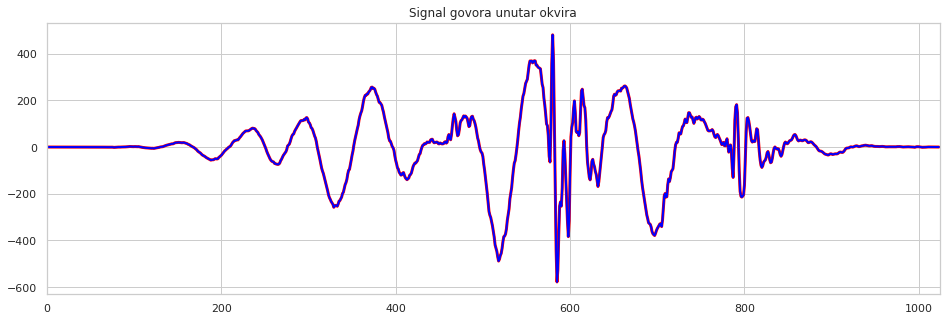

In [29]:
# short sagment - pick a short sagment
# segment zvučnog glasa izdvojen vremenskim otvorom (amplituda, vrijeme)

pos = 40000
frame_length = 1024 # dužina frame-a, u broju uzorka. ako bi željeli dobiti broj za neku dužinu u vremenu, moramo pomnožiti sampling rate tog zvuka s vremenom u sekundama
hop_length = 80 # number of steps to advance between frames. vrijede ista pravila kao i za frame_length 

#PRIMJER1 pysptk gitlab (xw)
xw = x[pos:pos+frame_length] * pysptk.blackman(frame_length) # blackman smanjuje amplitudu slijeva i sdesna
# https://www.dsprelated.com/freebooks/mdft/Use_Blackman_Window.html

#PRIMJER2 librosa gitlab (frames)
frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
frames *= pysptk.blackman(frame_length)

assert frames.shape[1] == frame_length 

print(len(frames))

plt.plot(xw, linewidth = 3.0, color='red')
plt.plot(frames[500], linewidth = 2.0, color='blue') #zašto baš 500? valjda zato da se ne dobije baš početak ili kraj gdje je samo tišina

plt.xlim(0, frame_length)
plt.title("Signal govora unutar okvira")

plt.savefig("./images/"+WAV+"/"+WAV+"_signalGovoraOkvir.png")

## Source excitation - Pobuđivanje

Pobuda je niz impulsa ili šum

Hop size = frame period in sample

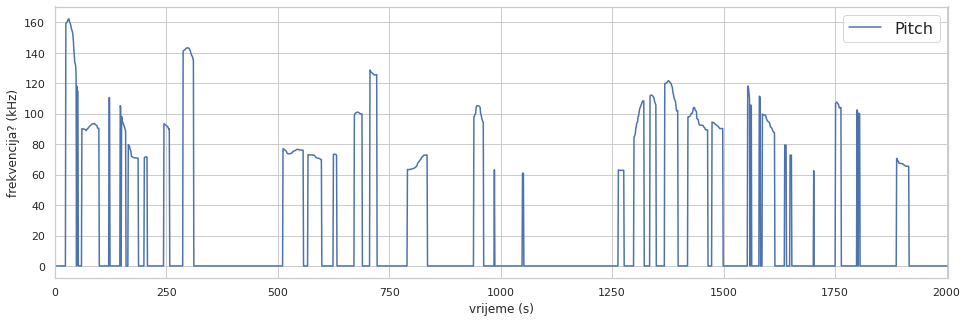

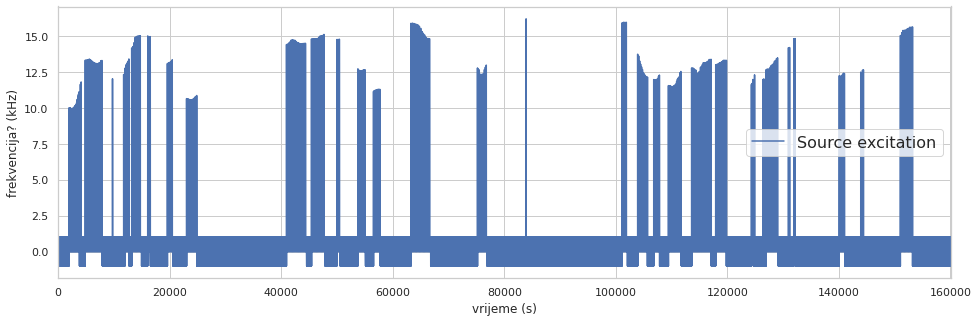

In [46]:

pitch = pysptk.swipe(x, fs=fs, hopsize=hop_length, min=60, max=900, otype="pitch")
# swipe - a saw-tooth waveform inspired pitch estimation
# params - a whole audio signal, sampling frequency, hop size, min i max fundamental frequency, output format = pitch

# source excitation je 
source_excitation = pysptk.excite(pitch, hop_length)
# excite - excitation generation
# params - pitch sequence, hop size ... returns excitation signal

# pojasniti ovaj grafički prikaz    

pitch = pysptk.swipe(x, fs=fs, hopsize=hop_length, min=60, max=900, otype="f0") # f0 da dobijemo frekvenciju
# pitch se povećava s jačinom ispuštanja zraka iz pluća
plt.figure()
plt.plot(pitch, label="Pitch")
plt.xlim(0, len(pitch))
plt.xlabel("vrijeme (s)") #podijeliti s 10 000
plt.ylabel("frekvencija? (kHz)") #provjeriti mjernu jedinicu
plt.legend(prop={'size': 16});
plt.savefig("./images/"+WAV+"/"+WAV+"_pitch.png")

# source excitation je jačina ispuštanja zraka, a potrebno je više zraka za dublji pitch
plt.figure()
plt.plot(source_excitation, label="Source excitation")
plt.xlim(0, len(source_excitation))
#plt.ylim(-5, 16)
plt.xlabel("vrijeme (s)") #podijeliti s 10 000
plt.ylabel("frekvencija? (kHz)") #provjeriti mjernu jedinicu
plt.legend(prop={'size': 16});
plt.savefig("./images/"+WAV+"/"+WAV+"_sourceExcitation.png")



In [31]:
##Synthesis from mel-cepstrum

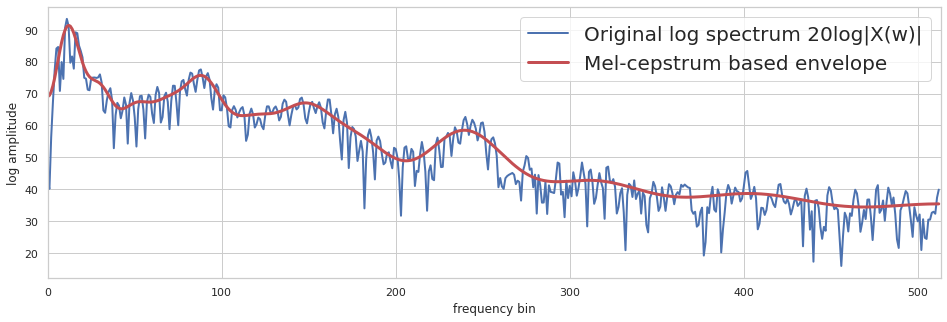

In [32]:
order = 25 # defaultna vrijednost za order kod mel-cepstruma
alpha = 0.42 

# Spectrum for a windowed signal - prirodni logaritam modula spektra ?
# izračun spectruma 20log|X(w)| za okvir 
sp = 20*np.log10(np.abs(np.fft.rfft(xw)))

mgc = pysptk.mcep(xw, order, alpha) # one frame = xw
pplot(sp, pysptk.mgc2sp(mgc, alpha, 0.0, frame_length).real, title="Mel-cepstrum based envelope")

plt.savefig("./images/"+WAV+"/"+WAV+"_melCepstrumEnvelope.png")

# zašto je 0.41? a u Lineaer frequency cepstrum based envelope je 0.0

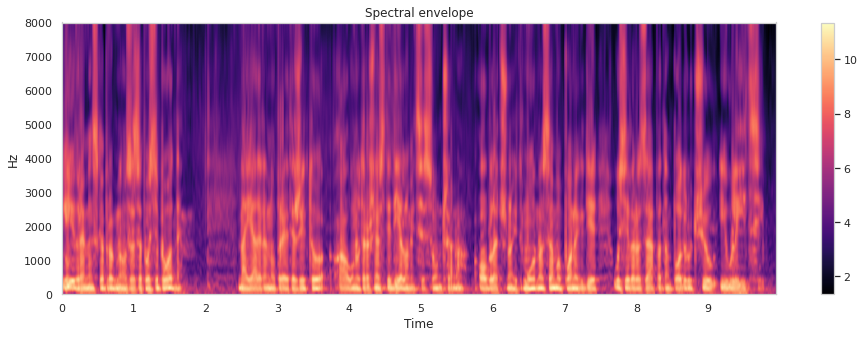

In [33]:
mc = pysptk.mcep(frames, order, alpha)
# mcep - mel-cepstrum analysis
# params - windowed frame, order of mel-cepstrum (default 25), alpha - all pass constant (default 0.35)

logH = pysptk.mgc2sp(mc, alpha, 0.0, frame_length).real
# mgc2sp - mel-generalized capstrum transform
# params - mel-generalized capstrum, all-pass constant, gamma, FFT length
# return - complex spectrum log_e(H(w))

librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
# specshow - display a spectogram
# params - matrix to display, sample rate, hop length, range for x and y axes

plt.colorbar()
plt.title("Spectral envelope");

plt.savefig("./images/"+WAV+"/"+WAV+"_spectralEnvelope.png")

In [34]:
## Source excitation generation

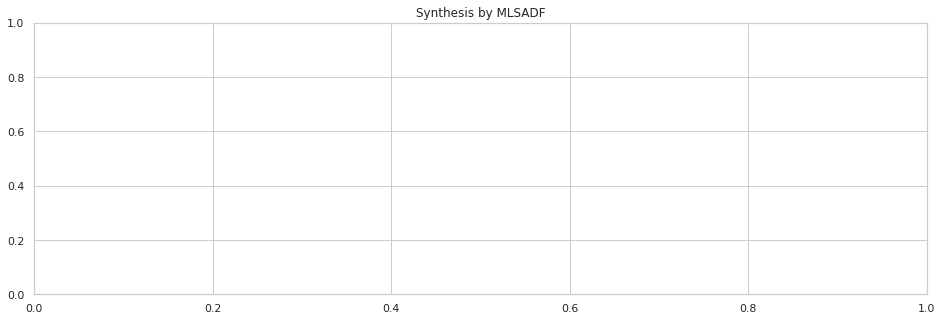

In [35]:
from pysptk.synthesis import MLSADF, Synthesizer

# Convert mel-cepstrum to MLSADF coefficients - "mel log spectrum approximation digital filter" that wraps mlsadf

b = pysptk.mc2b(mc, alpha)
# mc2b - mel-cepstrum to MLSA filter coefficients
# return - MLSA filter coefficients

synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), hop_length)
# synthesizer - speech waveform 
# params - a speech synthesis filter, hop size
# filter = MLSADF - MLSA digital filter that wraps mlsadf - params order of pade approximation (default = 4), all-pass constant


x_synthesized = synthesizer.synthesis(source_excitation, b)
# synthesis - synthesize a waveform given a source excitation and sequence of filter coefficients (e.g. cepstrum)
# params - source excitation, filter coefficients
# return - synthesized waveform

wavfile.write("./wav_mlsa/"+WAV+"_mlsa.wav", fs, x_synthesized.astype(np.int16))

#librosa.display.waveplot(x_synthesized, sr = fs)
plt.title("Synthesis by MLSADF")

plt.savefig("./images/"+WAV+"/"+WAV+"_synthesisMLSA.png")

Audio(x_synthesized, rate=fs)